# Running Monte Carlo over real files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import urllib.request
import json
from   collections import OrderedDict

import astropy.coordinates as coord
import astropy.units as u
from   astropy import time as t

import poliastro
from poliastro.bodies   import Earth
from poliastro.twobody  import Orbit
from poliastro.plotting import plot

import corner

import emcee

# Loading multiple files with a SINGLE satellite

In [2]:
ScaleFactor = 30 # Integer, reduces x ScaleFactor the number of measurements used to do the MCMC

In [3]:
c = 299792.458  # km/s

def GetDopplerShift(f_c, f_m):
    DS = (f_m - f_c)/f_c
    return DS
    
def get_v_radial(f_c, f_m):
    v_r = c * GetDopplerShift(f_c, f_m)
    return v_r

In [4]:
file_list = ['first_test/001_20190721T052832_jena.json',
             'first_test/001_20190721T052821_leipzig.json',
             'first_test/001_20190721T052801_settrup.json',
             'first_test/001_20190721T052806_stuttgart.json']

N = len(file_list)

In [5]:
raw_data = []

for filename in file_list:
    with open( filename, 'r') as myfile:
        data=myfile.read()
        raw_data.append(data)

In [6]:
json_files = []

for i in range(N):
    obj = json.loads(raw_data[i])
    json_files.append(obj)

In [7]:
gs_geodetic_locs = []

for i in range(N):
    gs_geodetic_locs.append( json_files[i]['groundstation'])


# Get Doppler Shift data from F_c and F_m

In [8]:
f_c = obj['data'][0]['channel_f_center']

In [9]:
tau = []
DS = []

for i in range(N):
    
    print("Sat ID: {}".format(json_files[i]['data'][0]['sat_id']))
    stream = json_files[i]['data'][0]['stream']
    
    aux_tau = []
    aux_DS   = []
    
    
    for s in range(len(stream)):
        if (s % ScaleFactor == 0):
            aux_tau.append( float(stream[s]['time_system']))
            aux_DS.append( GetDopplerShift(f_c, float(stream[s]['f']) ))

    print("Stream length: {}".format(len(aux_DS)))
    tau.append(aux_tau)
    DS.append(aux_DS)

Sat ID: 1
Stream length: 14
Sat ID: 1
Stream length: 14
Sat ID: 1
Stream length: 13
Sat ID: 1
Stream length: 14


In [10]:
M = 0

for i in range(N):
    print(len(tau[i]))
    M += len(tau[i])
    
print('Total number of Measurements M = {}'.format(M))

14
14
13
14
Total number of Measurements M = 55


### Doppler Shift measured by Ground Stations

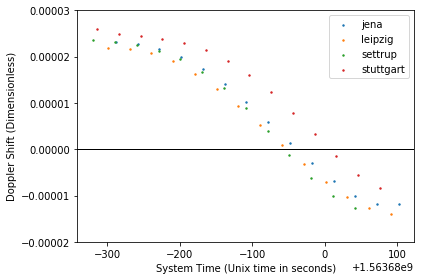

In [11]:
fig = plt.figure(figsize=(6,4))
plt.axhline(0, c="k", lw=1)

for i in range(N):
    
    label = gs_geodetic_locs[i]['gs_name']
    plt.scatter(tau[i], DS[i], s=2, label=label)
    
plt.ylim(-2e-5,3e-5)
plt.xlabel("System Time (Unix time in seconds)")
plt.ylabel("Doppler Shift (Dimensionless)")
plt.legend(loc=0)

plt.tight_layout()
plt.savefig("first_test/measured_doppler_shift.png")

In [12]:
Doppler_Uncertainty = 10**(-7)

### Calculating GS positions and velocities in the GeoCentric Reference System

In [13]:
gs_geodetic_locs

[{'gs_id': None,
  'gs_name': 'jena',
  'gs_lon': 11.56886,
  'gs_lat': 50.91847,
  'gs_alt': 130.0},
 {'gs_id': None,
  'gs_name': 'leipzig',
  'gs_lon': 12.338261,
  'gs_lat': 51.336569,
  'gs_alt': 80.0},
 {'gs_id': None,
  'gs_name': 'settrup',
  'gs_lon': 7.6289,
  'gs_lat': 52.49356,
  'gs_alt': 40.0},
 {'gs_id': None,
  'gs_name': 'stuttgart',
  'gs_lon': 9.2356,
  'gs_lat': 48.777,
  'gs_alt': 230.0}]

In [14]:
GS = []

for i in range(N):
    lon = gs_geodetic_locs[i]['gs_lon']
    lat = gs_geodetic_locs[i]['gs_lat']
    alt = gs_geodetic_locs[i]['gs_alt']
    
    gs = coord.EarthLocation(lon, lat, alt)
    
    GS.append(gs)

In [15]:
tau_astropytime = []

for i in range(N):
    aux = []
    for aux_t in tau[i]:
        theta = t.Time(aux_t, format='unix', scale='utc')
        aux.append(theta)
    tau_astropytime.append(aux)

In the next cell we calculate the velocity and the position of each ground station at each moment of measurement. It takes around 2 minutes per 400 observations.
%%In this case around 8 minutes per four stations (~1600 observations)

In [16]:
GS_gcrs_positions = []
GS_gcrs_velocities = []

for  i in range(N):
    aux_pos = []
    aux_vel = []
    
    print("iteration {} starts at time {}".format(i, t.Time.now()))
    for t0 in tau_astropytime[i]:
        p,v = GS[0].get_gcrs_posvel(obstime= t0)
        aux_pos.append(p)
        aux_vel.append(v)
    
    print("iteration {} ends at time {}".format(i, t.Time.now()))
    
    GS_gcrs_positions.append(aux_pos)
    GS_gcrs_velocities.append(aux_vel)

iteration 0 starts at time 2019-08-26 15:46:57.655075
iteration 0 ends at time 2019-08-26 15:47:02.660525
iteration 1 starts at time 2019-08-26 15:47:02.660975
iteration 1 ends at time 2019-08-26 15:47:06.145864
iteration 2 starts at time 2019-08-26 15:47:06.146869
iteration 2 ends at time 2019-08-26 15:47:09.592038
iteration 3 starts at time 2019-08-26 15:47:09.592668
iteration 3 ends at time 2019-08-26 15:47:13.563764


### How it looks:

In [17]:
GS_gcrs_positions[0][:3]

[<CartesianRepresentation (x, y, z) in m
     (4035733.15241229, 145414.66606224, 4920400.42424484)>,
 <CartesianRepresentation (x, y, z) in m
     (4035405.21181083, 154222.88050481, 4920401.1947472)>,
 <CartesianRepresentation (x, y, z) in m
     (4035058.0028907, 163030.35634386, 4920402.00126166)>]

In [18]:
GS_gcrs_velocities[0][:3]

[<CartesianRepresentation (x, y, z) in m / s
     (-10.61021292, 293.61897176, 0.02508017)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-11.25240431, 293.59512407, 0.02629072)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-11.89470239, 293.56979662, 0.02749369)>]

### Now we have the Ground Station location in XYZ in the Geocentric Inertial System.

Regading, this is the System where Satellite coordinates are measured.

In [19]:
for i in range(N):
    print(len(GS_gcrs_positions[i]), len(GS_gcrs_velocities[i]), len(tau_astropytime[i]))

14 14 14
14 14 14
13 13 13
14 14 14


### Initial position guess:

Well, let's try an XYZ-VxVyVz approximation to the orbital parameters, instead the classic elements.

1. Find average location of Ground Stations: GS_av
2. Extend this vector into space something like 500 km: R0
3. Find some points in a circle into a radius of 1000 km. The circle is centered at R0, in the plane defined by the vector GS_av
4. Define initial velocities towards R0 (or something tangential to Earths Surface).


In [20]:
GS_0x = []
GS_0y = []
GS_0z = []

for i in range(1):  ## range(1) takes only the first station, not the average of positions
    x, y, z = GS_gcrs_positions[i][0].xyz
    
    GS_0x.append(x.value)
    GS_0y.append(y.value)
    GS_0z.append(z.value)
    
GS_0xav = np.mean(GS_0x)
GS_0yav = np.mean(GS_0y)
GS_0zav = np.mean(GS_0z)

In [21]:
GS_gcrs_positions[0][0]

<CartesianRepresentation (x, y, z) in m
    (4035733.15241229, 145414.66606224, 4920400.42424484)>

In [22]:
GS_av = (GS_0xav, GS_0yav, GS_0zav)
print(GS_av)

(4035733.152412287, 145414.66606223976, 4920400.4242448425)


### Generate the initial positions of Random Walkers

In [23]:
def norm(A_list):
    A = 0
    for a in A_list:
        A += a**2
    return A**0.5

This is the average position of the Ground Stations at the first measurement.

In [24]:
GS_av_unitary = GS_av / norm(GS_av)

This is a point 500 kilometers above the GS_average point.

In [25]:
H_0 = 600 * u.km

Earth.R + H_0

<Quantity 6978136.6 m>

In [26]:
R0 = (Earth.R + H_0) * GS_av_unitary
print(R0)

[4424197.89054623  159411.74367847 5394019.96005977] m


And a random initial velocity, just to test the Orbit Generation from vectors

In [27]:
GM_E = poliastro.constants.GM_earth

V0 = (GM_E / (Earth.R + H_0))**0.5

In [28]:
V0

<Quantity 7557.86542315 m / s>

In [29]:
V0.value

7557.86542314838

# Orbit generated from vectors

In [30]:
nwalkers = 100
ndim = 6
MCMC_steps = 50

In [31]:
## To generate circular orbits with initial positions above the first measurement.

z_unitary = np.array([0, 0, 1])
vec_in_plane = np.cross(z_unitary, GS_av_unitary)
v_1 = vec_in_plane / norm( list(vec_in_plane) ) # v_1 = ẑ x n   ## Parallel to XY plane
v_2 = np.cross( GS_av_unitary, v_1 )


DeltaR0 = 500
DeltaV0 = 5

def init_R0s(R0, nwalkers):
    R0x = R0[0]
    R0y = R0[1]
    R0z = R0[2]
      
    retx = np.random.normal(R0x, DeltaR0, nwalkers)
    rety = np.random.normal(R0y, DeltaR0, nwalkers)
    retz = np.random.normal(R0z, DeltaR0, nwalkers)
    
    ret = np.array([retx, rety, retz])
    return ret.T

def init_V0s(V1, V2, nwalkers):
    
    theta = (np.random.random(nwalkers) - 0.5) * np.pi * 0.1
    
    A1 = V1 * np.ones([nwalkers, 3]) * V0.value * (np.ones([nwalkers, 3]).T * np.cos( 2 * np.pi * theta) ).T
    A2 = V2 * np.ones([nwalkers, 3]) * V0.value * (np.ones([nwalkers, 3]).T * np.sin( 2 * np.pi * theta) ).T

    ret =  A1 + A2

    return ret
    

# Likelihood

In [32]:
c = 299792.458 * u.km / u.s

def redshift(f_0, Vradial ):
    
    return f_0 * (1 + Vradial / c)

In [33]:
R = init_R0s( (R0[0].value, R0[1].value, R0[2].value) , nwalkers)
V = init_V0s( v_1, v_2 ,nwalkers)
P0 = np.hstack((R,V))
P0[:,:]

array([[ 4.42475186e+06,  1.59518351e+05,  5.39426024e+06,
        -1.52715633e+03,  7.32911108e+03,  1.03597975e+03],
       [ 4.42379782e+06,  1.58866908e+05,  5.39367755e+06,
        -2.19255135e+03,  7.05595817e+03,  1.58981215e+03],
       [ 4.42494213e+06,  1.59231088e+05,  5.39351097e+06,
         7.60471559e+02,  7.47192920e+03, -8.44563046e+02],
       [ 4.42353844e+06,  1.58429436e+05,  5.39464436e+06,
         3.47741709e+03,  5.98774971e+03, -3.02915064e+03],
       [ 4.42334232e+06,  1.59689343e+05,  5.39411759e+06,
        -1.30019590e+03,  7.39675674e+03,  8.47826686e+02],
       [ 4.42376766e+06,  1.59077204e+05,  5.39427764e+06,
        -3.39641608e+03,  6.23034718e+03,  2.60162670e+03],
       [ 4.42369052e+06,  1.58554412e+05,  5.39401725e+06,
         3.32186314e+03,  6.13531989e+03, -2.90592583e+03],
       [ 4.42421297e+06,  1.59604004e+05,  5.39437204e+06,
        -4.52535815e+03,  4.89056807e+03,  3.56718480e+03],
       [ 4.42418712e+06,  1.59770450e+05,  5.393

In [34]:
TestOrbit = Orbit.from_vectors(Earth, P0[0][:3] * u.m, P0[0][3:] * u.m/u.s, epoch=tau_astropytime[0][0] )

In [35]:
def lnprob( param ):
    x, y, z, vx, vy, vz = param
    
    r = (x**2 + y**2 + z**2)**0.5
    
    # Reject orbits "inside" the Earth
    if Earth.R.value > r:        
        print(r)
        return -np.inf
    
    tau_0 = tau_astropytime[0][0]
    r_init = np.array([x,y,z]) * u.m
    v_init = np.array([vx, vy, vz]) * u.m / u.s
    myOrbit = Orbit.from_vectors(Earth, r_init, v_init, epoch=tau_0)
    
    
    # Reject hyperbolic orbits
    if(myOrbit.a.value <0):
        #print("Negative major semi-axe. CHECK INITIAL SPEED and its UNITS")
        return -np.inf
    
    # If the perigee is less than Earth Radius.
    if( TestOrbit.a * (1-TestOrbit.ecc) < Earth.R):
        #print("Orbit fails. crash")
        return -np.inf
    else:
        #print("Good orbit!")
        #print("Orbit Eccentricity: {}".format(myOrbit.ecc))
        1
        
    # Reject very excentric orbits orbits
    if(myOrbit.ecc.value > 0.3):
        return -np.inf

    chi2 = 0
    for i in range(N):
        for j in range(len(tau_astropytime[i])):
            chi_aux = 0
            
            t_prime = tau_astropytime[i][j]
            DeltaT = t_prime - tau_0
            
            orbit_at_t_prime = myOrbit.propagate(DeltaT)
                        
            r_sat = orbit_at_t_prime.state.r
            v_sat = orbit_at_t_prime.state.v
            
            r_gs  = GS_gcrs_positions[i][j].get_xyz()
            v_gs  = GS_gcrs_velocities[i][j].get_xyz()

            
            r      = r_sat - r_gs
            r_unit =  r / norm(r)
            v      = v_sat - v_gs
            
            ds_mcmc = v.dot(-r_unit)/c
            ds_obs  = DS[i][j]
            
            chi_aux = -0.5 * ((ds_mcmc - ds_obs) / Doppler_Uncertainty )**2 / (M - 6)
            
            #print( 'Chi2 {:03.8f} measured {:03.8f} mcmcm {:03.8f} '.format(chi_aux, ds_obs, ds_mcmc) )
            
            
            chi2 += chi_aux

    print("Chi2 = {}".format(chi2))
    return chi2

In [36]:
for i in range(1):
    lnprob(P0[i])

Chi2 = -40592.157424669604


In [37]:
emcee.__version__

'2.2.1'

In [38]:
t_mcmc_start = t.Time.now()

print(" MCMC running with {} walkers, {} Steps. Starts at t={}".format(nwalkers, MCMC_steps, t_mcmc_start))

 MCMC running with 100 walkers, 50 Steps. Starts at t=2019-08-26 15:47:16.472849


In [39]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

pos, prob, state = sampler.run_mcmc(P0, MCMC_steps)

Chi2 = -41415.23107805189
Chi2 = -40531.43310220091
Chi2 = -40803.756484917896
Chi2 = -40592.157424669604
Chi2 = -40619.38541306553
Chi2 = -40647.34249771218
Chi2 = -41530.064027916866
Chi2 = -40687.381190440945
Chi2 = -40762.95204127645
Chi2 = -40585.46574443078
Chi2 = -40589.745840074174
Chi2 = -41589.34263441582
Chi2 = -40536.221368071354
Chi2 = -40585.47082776615
Chi2 = -41116.03557611715
Chi2 = -40682.504683987565
Chi2 = -40579.50664058776
Chi2 = -40667.870503284
Chi2 = -40610.31588954972
Chi2 = -40529.622526418214
Chi2 = -41225.42945055807
Chi2 = -40608.80725900375
Chi2 = -40962.76367621209
Chi2 = -40554.32561387454
Chi2 = -40801.317012935826
Chi2 = -40694.870317608686
Chi2 = -40532.39456529124
Chi2 = -41084.9817741221
Chi2 = -40569.168838708814
Chi2 = -40561.676257173414
Chi2 = -41617.85473650036
Chi2 = -40983.332903184964
Chi2 = -40530.939136177796
Chi2 = -40672.75635859723
Chi2 = -40652.011817949904
Chi2 = -40524.777758213975
Chi2 = -40554.31042824407
Chi2 = -40856.9395425757


Chi2 = -38614.59720461564
Chi2 = -37743.90436537925
Chi2 = -45311.24624543887
Chi2 = -40359.47624893796
Chi2 = -47757.4009439209
Chi2 = -44360.72003873401
Chi2 = -36050.092178601415
Chi2 = -38613.02911425176
Chi2 = -43221.04564137328
Chi2 = -34675.371506892654
Chi2 = -33692.135343397094
Chi2 = -38916.09993657497
Chi2 = -38879.26473355019
Chi2 = -34412.56430844606
Chi2 = -39181.59162168448
Chi2 = -41880.38500357568
Chi2 = -41440.80965268904
Chi2 = -38831.0888769044
Chi2 = -38875.83886551634
Chi2 = -39838.050230515175
Chi2 = -37099.498110162334
Chi2 = -37853.4970669978
Chi2 = -35636.94168555986
Chi2 = -36023.2017091929
Chi2 = -34450.396628844166
Chi2 = -33546.98252778292
Chi2 = -37150.02870007371
Chi2 = -48986.58033050689
Chi2 = -41662.78438648123
Chi2 = -50341.873414425274
Chi2 = -43018.55607327486
Chi2 = -37557.87833211539
Chi2 = -35426.36328263692
Chi2 = -39537.57426412754
Chi2 = -37615.461811408124
Chi2 = -43922.96776724061
Chi2 = -45543.502242743416
Chi2 = -34381.146947660294
Chi2 =

Chi2 = -38131.010413387135
Chi2 = -35588.94262040605
Chi2 = -32826.89027195965
Chi2 = -40123.03258104087
Chi2 = -34081.36860230113
Chi2 = -38676.67664762483
Chi2 = -32501.05447125995
Chi2 = -38022.370292292864
Chi2 = -31785.592611740663
Chi2 = -38857.538014667414
Chi2 = -39735.38438696985
Chi2 = -38483.92635119227
Chi2 = -42932.78623897798
Chi2 = -31402.85014148208
Chi2 = -34093.79878040137
Chi2 = -39767.1846549836
Chi2 = -38903.45625671844
Chi2 = -39676.63518883246
Chi2 = -39326.8966642762
Chi2 = -35052.241952840515
Chi2 = -32722.321679771056
Chi2 = -31380.588570618373
Chi2 = -31971.966392708728
Chi2 = -33300.51163094465
Chi2 = -32014.10301939401
Chi2 = -33357.30739988375
Chi2 = -32360.135971002965
Chi2 = -38171.90764945892
Chi2 = -33951.10289520794
Chi2 = -33830.839509783116
Chi2 = -39148.334902125
Chi2 = -35466.900096151585
Chi2 = -33010.2970025705
Chi2 = -38873.476105234295
Chi2 = -35761.82497381241
Chi2 = -32824.05016366485
Chi2 = -37320.748582349144
Chi2 = -35252.644408079424
Chi

Chi2 = -33356.36199885806
Chi2 = -31844.96008033287
Chi2 = -44299.87380122626
Chi2 = -33786.16285316212
Chi2 = -36460.64475035499
Chi2 = -37044.42953537977
Chi2 = -31365.740712488194
Chi2 = -32379.952172867062
Chi2 = -33571.68143768632
Chi2 = -31092.96934669064
Chi2 = -35635.91527509314
Chi2 = -31093.94810246043
Chi2 = -34805.3650165404
Chi2 = -35588.63324478026
Chi2 = -34409.633480636476
Chi2 = -45222.431553312636
Chi2 = -32482.389504581723
Chi2 = -31016.397092117033
Chi2 = -31120.715061644
Chi2 = -42647.40757675077
Chi2 = -38909.569170121526
Chi2 = -31707.167661707983
Chi2 = -46126.36912609895
Chi2 = -39360.850556088146
Chi2 = -34482.62163745836
Chi2 = -44811.73620931753
Chi2 = -42453.41631600025
Chi2 = -34393.30611841778
Chi2 = -41188.15163600818
Chi2 = -32211.598568505513
Chi2 = -35040.53768959616
Chi2 = -37291.02331116059
Chi2 = -39772.374224801715
Chi2 = -32240.36850556644
Chi2 = -36572.98353243752
Chi2 = -31147.373115178412
Chi2 = -32257.858140056902
Chi2 = -36345.62544410347
Ch

Chi2 = -34461.416163657355
Chi2 = -31597.9509191846
Chi2 = -32604.200466960476
Chi2 = -33208.99694547431
Chi2 = -33137.546339252134
Chi2 = -37178.65084439552
Chi2 = -31331.803182226733
Chi2 = -31921.499739282
Chi2 = -31015.76524289957
Chi2 = -31502.72942582934
Chi2 = -39358.645110810656
Chi2 = -31200.331317226464
Chi2 = -37210.270997893356
Chi2 = -32743.7096274685
Chi2 = -33058.23697547584
Chi2 = -33033.0626464648
Chi2 = -32760.410621453982
Chi2 = -40610.77825881132
Chi2 = -33985.59854291341
Chi2 = -32301.891759267277
Chi2 = -40563.17284495286
Chi2 = -34417.71727791361
Chi2 = -33401.38962463082
Chi2 = -30980.05909202264
Chi2 = -36716.02490497132
Chi2 = -38387.25377450637
Chi2 = -35938.28404119404
Chi2 = -32437.22085927529
Chi2 = -31296.263208010816
Chi2 = -31550.88736820827
Chi2 = -32461.828015413692
Chi2 = -32930.280749077385
Chi2 = -38278.658572721266
Chi2 = -32224.872691606553
Chi2 = -32189.737240324383
Chi2 = -33439.241990555965
Chi2 = -31612.205009440157
Chi2 = -45613.812073063185

Chi2 = -32092.220684366544
Chi2 = -35370.57521650624
Chi2 = -31632.781952344176
Chi2 = -33947.95199636979
Chi2 = -31135.04024502753
Chi2 = -34025.622922061564
Chi2 = -30989.337769925223
Chi2 = -31308.47464935839
Chi2 = -35098.52830934014
Chi2 = -32356.90433293302
Chi2 = -31310.51378937293
Chi2 = -36002.149366406455
Chi2 = -30991.014130287855
Chi2 = -33493.81783272683
Chi2 = -31465.268811378875
Chi2 = -48718.49603144288
Chi2 = -34582.43082573129
Chi2 = -31491.245550220985
Chi2 = -33672.13394906588
Chi2 = -31327.076873140788
Chi2 = -33715.45636077515
Chi2 = -32766.613403290223
Chi2 = -35132.01754324262
Chi2 = -37755.32686598371
Chi2 = -40645.0907539478
Chi2 = -31966.92539696948
Chi2 = -36320.40864055513
Chi2 = -32315.519235051823
Chi2 = -48237.55975135254
Chi2 = -33311.46873798787
Chi2 = -32127.372417859468
Chi2 = -41452.67303516709
Chi2 = -34351.48092765644
Chi2 = -31323.49100096422
Chi2 = -32237.244712668737
Chi2 = -34032.267527180535
Chi2 = -31333.04875755397
Chi2 = -31367.3634881753


Chi2 = -31180.115963536395
Chi2 = -32658.031064271814
Chi2 = -31635.73237721169
Chi2 = -31922.83304305725
Chi2 = -37456.9577530197
Chi2 = -34423.545291565526
Chi2 = -31990.77788467361
Chi2 = -31189.6256580549
Chi2 = -31951.04858454378
Chi2 = -31517.429037490318
Chi2 = -34216.969384696255
Chi2 = -31036.059870395413
Chi2 = -37680.26841125718
Chi2 = -31020.503711114547
Chi2 = -34973.70909463672
Chi2 = -48806.86089354167
Chi2 = -37601.42745617155
Chi2 = -32457.414808367284
Chi2 = -33303.283987463285
Chi2 = -33830.39974540634
Chi2 = -34911.527517155
Chi2 = -33882.04894643827
Chi2 = -31373.902766452156
Chi2 = -34855.974239644434
Chi2 = -41666.49828028172
Chi2 = -32566.080964071127
Chi2 = -31208.403685102658
Chi2 = -38769.47910007756
Chi2 = -31050.373749917617
Chi2 = -30920.15136469282
Chi2 = -35408.308294740884
Chi2 = -31236.81900414792
Chi2 = -32715.07596024315
Chi2 = -31073.051939127923
Chi2 = -35258.0594623356
Chi2 = -35715.35714518066
Chi2 = -32753.547819001556
Chi2 = -49153.004796906476

Chi2 = -31282.571896903395
Chi2 = -31078.936277331948
Chi2 = -31090.440363516016
Chi2 = -31847.515694412396
Chi2 = -31909.43306737352
Chi2 = -31066.682663860967
Chi2 = -31713.160073906074
Chi2 = -34575.72427935842
Chi2 = -30900.622157981546
Chi2 = -31454.987200087337
Chi2 = -31574.279104613805
Chi2 = -33101.617624251005
Chi2 = -36060.708456927125
Chi2 = -31119.50261644077
Chi2 = -31012.245885252054
Chi2 = -31247.963267911065
Chi2 = -31138.54779047039
Chi2 = -30975.609995257142
Chi2 = -34341.366765662606
Chi2 = -31206.244355669292
Chi2 = -31277.809855098796
Chi2 = -30995.91298366011
Chi2 = -31806.759045833056
Chi2 = -31743.889170035956
Chi2 = -32136.231363100655
Chi2 = -33641.10731366804
Chi2 = -34462.06464687808
Chi2 = -30890.384979512528
Chi2 = -31143.00406620204
Chi2 = -36172.85314574359
Chi2 = -34710.87474506577
Chi2 = -33023.14688116446
Chi2 = -41105.036058249876
Chi2 = -30885.441615384934
Chi2 = -31199.541768708546
Chi2 = -32666.978872985746
Chi2 = -32122.181030390693
Chi2 = -3373

Chi2 = -30879.73139329135
Chi2 = -30931.990124538734
Chi2 = -34773.742108803584
Chi2 = -32302.190844535628
Chi2 = -30955.362337156963
Chi2 = -31445.27389830287
Chi2 = -30966.717063850127
Chi2 = -31034.334770973102
Chi2 = -30901.186614153616
Chi2 = -31014.886178671346
Chi2 = -30978.175676756808
Chi2 = -32917.07187806319
Chi2 = -31802.261230212993
Chi2 = -30908.117680542007
Chi2 = -31029.12448217504
Chi2 = -30981.961311876057
Chi2 = -32018.649117202018
Chi2 = -31038.01073279303
Chi2 = -31154.664484976
Chi2 = -32075.707592414303
Chi2 = -30882.869731132447
Chi2 = -31010.65908389759
Chi2 = -31991.814845536424
Chi2 = -31951.580059127333
Chi2 = -33164.153115700574
Chi2 = -31123.034123048565
Chi2 = -31981.58700262756
Chi2 = -33107.77228743921
Chi2 = -31570.247254543126
Chi2 = -37966.6348712403
Chi2 = -31280.524702098726
Chi2 = -31739.744438194226
Chi2 = -31314.98833812999
Chi2 = -34641.30168564829
Chi2 = -32210.578840554146
Chi2 = -31076.526237984963
Chi2 = -31295.726959413314
Chi2 = -31274.59

Chi2 = -30970.662706217936
Chi2 = -30991.442557016784
Chi2 = -39816.0636145264
Chi2 = -30986.782776174634
Chi2 = -31346.18049773858
Chi2 = -31527.634131516064
Chi2 = -31102.870522990637
Chi2 = -31298.717427396423
Chi2 = -31011.872102174464
Chi2 = -32174.520500092134
Chi2 = -31884.22836234519
Chi2 = -30898.28455257639
Chi2 = -31246.235583053975
Chi2 = -31397.17770521517
Chi2 = -33827.85135841743
Chi2 = -34297.57489635735
Chi2 = -31079.432462094934
Chi2 = -31059.934162736765
Chi2 = -31647.667810896724
Chi2 = -31523.81273503696
Chi2 = -31488.610796804496
Chi2 = -31225.718512350548
Chi2 = -34133.140689397085
Chi2 = -34363.18520533844
Chi2 = -31948.087546124338
Chi2 = -33297.55803083779
Chi2 = -31140.47917847452
Chi2 = -31408.41421994169
Chi2 = -31229.592570963225
Chi2 = -31395.844256847904
Chi2 = -31076.480965971863
Chi2 = -30909.06289816446
Chi2 = -32570.99071114915
Chi2 = -30931.947064615888
Chi2 = -30825.205411636474
Chi2 = -31509.808749553238
Chi2 = -34191.06594677796
Chi2 = -31928.497

Chi2 = -30870.59586932198
Chi2 = -31442.359375128795
Chi2 = -30814.469571859227
Chi2 = -31039.0227633738
Chi2 = -31620.287840974714
Chi2 = -45191.90406975357
Chi2 = -30972.58570907486
Chi2 = -31680.234805688142
Chi2 = -36651.3497128926
Chi2 = -30959.201940108796
Chi2 = -34543.02462009169
Chi2 = -31536.298513597583
Chi2 = -30913.91152893381
Chi2 = -34031.821528613786
Chi2 = -34808.5233720865
Chi2 = -30998.444082458933
Chi2 = -30923.603260528496
Chi2 = -32321.82315182315
Chi2 = -31038.031130536132
Chi2 = -33281.97287305693
Chi2 = -31239.37758039741
Chi2 = -31056.655863234697
Chi2 = -30951.377926240686
Chi2 = -32015.769914122742
Chi2 = -31532.586727633
Chi2 = -30924.08593409679
Chi2 = -31775.118385792222
Chi2 = -31289.879543771593
Chi2 = -31068.223557107613
Chi2 = -31093.04443248338
Chi2 = -30940.026988103742
Chi2 = -30871.611895224836
Chi2 = -32835.35847784614
Chi2 = -31578.57625099906
Chi2 = -30884.54681571301
Chi2 = -31256.90608528266
Chi2 = -32041.446009120085
Chi2 = -31049.2505539579

Chi2 = -31114.669252178865
Chi2 = -31229.023957301008
Chi2 = -31274.16649291893
Chi2 = -30961.899301346064
Chi2 = -31017.9611862091
Chi2 = -30878.832684292236
Chi2 = -31111.6452650014
Chi2 = -31024.846995319265
Chi2 = -31065.805060523337
Chi2 = -33401.477642466925
Chi2 = -31209.637673989306
Chi2 = -34324.024297282485
Chi2 = -30933.297554812867
Chi2 = -30961.48882562573
Chi2 = -30998.225893738112
Chi2 = -31419.005120700338
Chi2 = -30929.96504215546
Chi2 = -30890.44000641564
Chi2 = -32234.244627964472
Chi2 = -31336.43746612447
Chi2 = -30939.94676300938
Chi2 = -30994.86280613857
Chi2 = -37380.418928587256
Chi2 = -31066.72427724947
Chi2 = -31323.47612148771
Chi2 = -30977.414984028535
Chi2 = -30902.006069798583
Chi2 = -30880.94041315045
Chi2 = -31041.845722852326
Chi2 = -33210.095002313115
Chi2 = -37746.806475699486
Chi2 = -35089.119188064346
Chi2 = -36375.11086154589
Chi2 = -37433.33423887224
Chi2 = -32298.040736619263
Chi2 = -31343.764008940518
Chi2 = -30917.599983335407
Chi2 = -31209.085

Chi2 = -30903.725374481528
Chi2 = -39104.51873065731
Chi2 = -30879.669963193617
Chi2 = -31027.466806751665
Chi2 = -33671.792896166895
Chi2 = -39356.9127155927
Chi2 = -30960.592953344723
Chi2 = -31836.038509864527
Chi2 = -42583.908765742264
Chi2 = -30884.287095223448
Chi2 = -30883.55616479198
Chi2 = -30908.990980502906
Chi2 = -32470.600193757768
Chi2 = -31414.19357972182
Chi2 = -36059.58909919822
Chi2 = -31069.023216325953
Chi2 = -31222.246970845255
Chi2 = -31090.670367551098
Chi2 = -32905.23116325223
Chi2 = -33662.9811979909
Chi2 = -30888.906123219134
Chi2 = -30888.90663902858
Chi2 = -33440.54620245016
Chi2 = -31100.093341942946
Chi2 = -35669.24341298174
Chi2 = -31080.720334513688
Chi2 = -30934.21728450428
Chi2 = -30958.18040696337
Chi2 = -32023.02708728017
Chi2 = -30933.735498387716
Chi2 = -30906.78346156606
Chi2 = -30918.17327733321
Chi2 = -31625.930332526583
Chi2 = -32980.3917692267
Chi2 = -30919.82373918478
Chi2 = -30922.58732495977
Chi2 = -30976.833660399887
Chi2 = -31247.72532038

# Now, run the MCMC

In [40]:
t_mcmc_end = t.Time.now()
print(" MCMC running ends at t={}".format( t_mcmc_end))

DeltaT_mcmc = (t_mcmc_end - t_mcmc_start)
print("{} seconds".format(DeltaT_mcmc.sec))

 MCMC running ends at t=2019-08-26 16:21:17.035634
2040.5627850000064 seconds


In [51]:
2040/60

34.0

In [42]:
samples = sampler.chain[:,0:,:].reshape((-1, ndim))


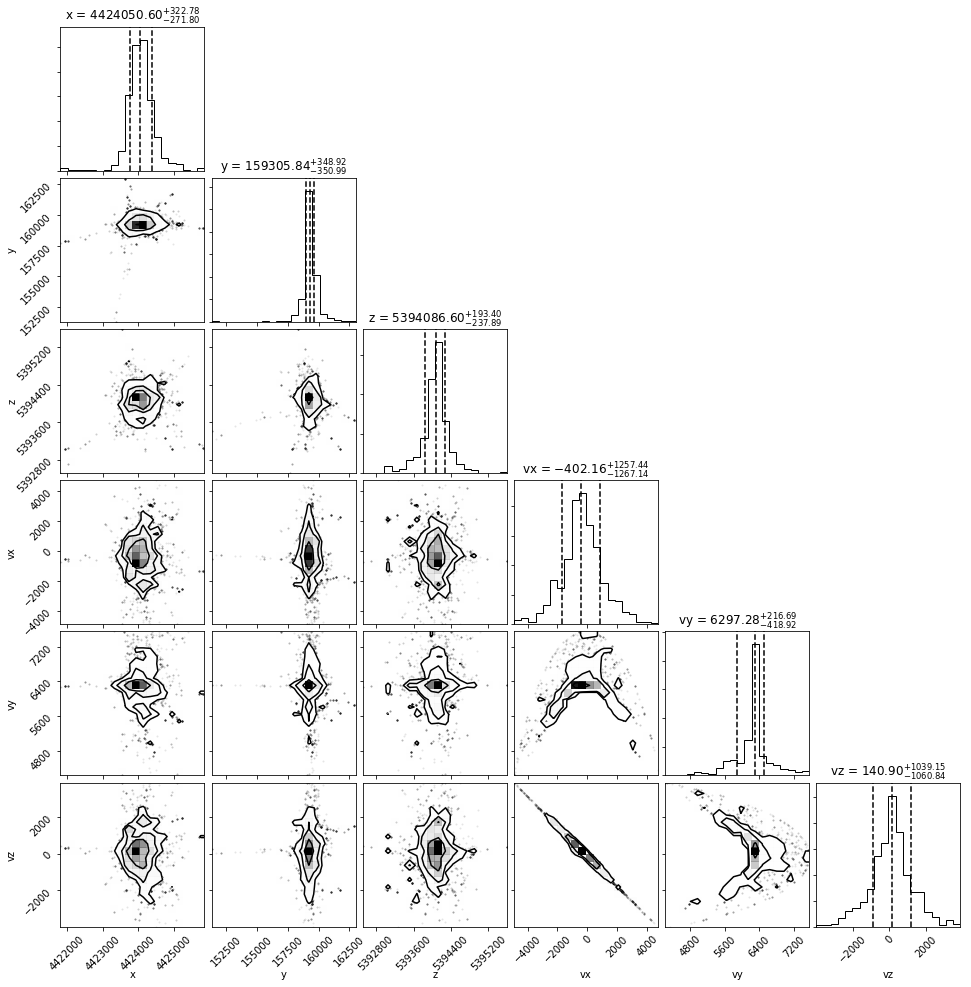

In [55]:
fig = corner.corner(samples, labels=["x", "y", "z", "vx", "vy", "vz"]
                    , show_titles=True
                    , plot_datapoints=True
                    , quantiles=[0.16,0.5, 0.84])

In [44]:
sampler.chain.shape

(100, 50, 6)

In [45]:
prob = sampler.lnprobability.ravel()

In [46]:
prob

array([-37073.53635673, -37073.53635673, -37073.53635673, ...,
       -30882.62493195, -30882.62493195, -30882.62493195])

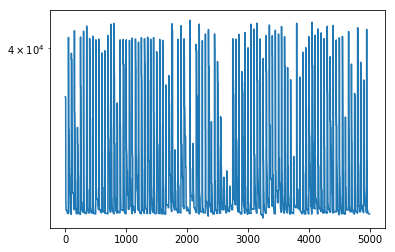

In [54]:
plt.plot(-prob)
plt.yscale("log")

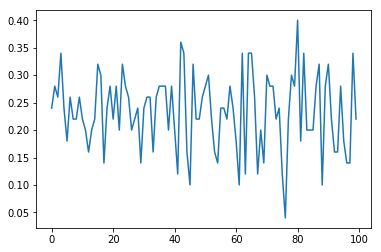

In [48]:
plt.plot(sampler.acceptance_fraction)

In [56]:
X_m  = samples[:,0].mean() 
Y_m  = samples[:,1].mean() 
Z_m  = samples[:,2].mean() 
VX_m = samples[:,3].mean() 
VY_m = samples[:,4].mean() 
VZ_m = samples[:,5].mean() 

best_fit_orbit = Orbit.from_vectors(Earth, 
                                    [X_m, Y_m, Z_m] * u.m, 
                                    [VX_m, VY_m, VZ_m] * u.m / u.s, 
                                    epoch=tau_astropytime[0][0])

In [64]:
best_fit_orbit.state.a

<Quantity 5306.61476817 km>

In [65]:
best_fit_orbit.state.ecc

<Quantity 0.31498022>

In [66]:
(best_fit_orbit.state.inc).to(u.deg)

<Quantity 50.63894167 deg>

In [67]:
(best_fit_orbit.state.raan).to(u.deg)

<Quantity 273.92892993 deg>

In [68]:
(best_fit_orbit.state.argp).to(u.deg)

<Quantity 268.81398762 deg>

In [69]:
(best_fit_orbit.state.nu).to(u.deg)

<Quantity 180.00186318 deg>

In [74]:
print("a\t",best_fit_orbit.state.a)
print("ecc\t", best_fit_orbit.state.ecc)
print("inc\t", (best_fit_orbit.state.inc).to(u.deg))
print("raan\t", (best_fit_orbit.state.raan).to(u.deg))
print("argp\t", (best_fit_orbit.state.argp).to(u.deg))
print("nu\t", (best_fit_orbit.state.nu).to(u.deg))

a	 5306.614768170868 km
ecc	 0.3149802185614126
inc	 50.638941674650006 deg
raan	 273.92892993140003 deg
argp	 268.81398761639923 deg
nu	 180.00186317578218 deg
